In [1]:
from ROOT import *

Welcome to JupyROOT 6.24/06


In [2]:
import sys,os,string
import particle
from particle import Particle
from ROOT import TGenPhaseSpace
from ROOT import TLorentzVector
from array import *
# code to explore particles in a GENIE tuple.  It assumes true T -> measured T
# decays Hyperons crudely
# HMS 2022-08-28

In [3]:
# control
TUPLEDUMP=False
ProtonCut = 0.120
PionCut = 0.05
maxcount = 1000000

In [4]:
# helpers

def makehist(ntuple,var,select):
    print (var)
    ntuple.Draw(var,select)
    htemp = TH1D()
    htemp = gPad.GetPrimitive("htemp")
    if "TH" not in str(type(htemp)):
        return None
    thehist = TH1F()
    thehist = htemp.Clone(var)
    htemp.Delete()
    return thehist
 
# count # of true primary pions

def npions(pdglist,npdg):
    npion = 0
    for part in pdglist:
        both = abs(part)
        if both == 111 or both == 211 :
            npion += 1
    return npion
    
# count # of photons with E > 10 MeV
def nphotons(pdglist,elist,npdg):  # of photons above 10 MeV
    n = 0
    for i in range(0,npdg):
        if pdglist[i] == 22 and elist[i] > 0.01:
            n += 1
    return n
 
# count # of protons with T > ProtonCut

def nprotons(pdglist,elist,npdg):
    n = 0
    for i in range(0,npdg):
        if pdglist[i] == 2212 and elist[i]-.9382 > ProtonCut:
            n += 1
    return n
 
# implement Amit's recoil cut
def RecoilCut(recoil,Q2):
      
     offset=0.05;
     if( Q2 < 0.175 ): return ( recoil <= 0.08+offset);
     if( Q2 < 1.4 ): return (recoil <= 0.03 + 0.3*Q2+offset);
     return (recoil <= 0.45+offset); #antinu

In [5]:
    
d_filename = "flat_GENIE_1000k_tune_G18_02a_02_11a_50MCombined_RHC.root"
filename = d_filename
ofilename = "pdg_"+filename
inputfile = TFile.Open(filename,'READONLY')

ntuple = inputfile.Get("FlatTree_VARS")
outputfile = TFile.Open(ofilename,"RECREATE")
#print (ntuple.GetListOfBranches())
select = "Enu_true > 1.5 && Enu_true < 20. && ELep > 1.5 && CosLep > 0.939693 && PDGnu == -14 && PDGLep < 0"
notinteresting = []

In [6]:
# code to dump all the variables in a tuple
if TUPLEDUMP:
    print ("dump the variables")
    count = 0
    for p in ntuple.GetListOfBranches():
        count +=1

        branchLength = ntuple.GetLeaf(p.GetName()).GetLen()
        branch = p.GetName()
        if "flag" in branch:
            break
        if branchLength > 1:
            continue

        if branch in notinteresting:
            continue
        ahist = makehist(ntuple,branch,select)
        ahist.Print()
        outputfile.cd()
        ahist.Write()

In [7]:
# loop over the entries in the tuple and try to see if there are hyperons that could pass CCQE cuts

nEntries = ntuple.GetEntries()

parts = {}
partT = {}
partTs = {}
icount = 0
pions = TH1F("nPi","number of pions",10,0.,10.)
photons = TH1F("nPhoton","number of photons > 10 MeV",10,0.,10.)
baryons = ["Lambda","Sigmaminus","Sigma0"]
hyperP={}
hypercharged = {}
hyperzero = {}
hypertotC = {}
hypertot0 = {}
hyperpassC = {}
hyperpass0 = {}

# here C means Proton+X and 0 means Neutron+X
for baryon in baryons:
    hyperP[baryon] = TH1F("T_p_%s"%baryon,"T of p from %s, GeV"%baryon,100,0.,0.5)
    hypercharged[baryon] = TH1F("T_pipm_%s"%baryon,"T of charge pion from %s, GeV"%baryon,100,0.,0.5)
    hyperzero[baryon] = TH1F("E_pizero_%s"%baryon,"E of neutral pion from %s, GeV"%baryon,100,0.,0.5)
    hyperpassC[baryon] = TH1F("E_passC_%s"%baryon,"Visible E from %s charged, GeV, passes cut"%baryon,100,0.,0.5)
    hyperpass0[baryon] = TH1F("E_pass0_%s"%baryon,"Visible E from %s neutral, GeV, passes cut"%baryon,100,0.,0.5)
    hypertotC[baryon] = TH1F("E_visC_%s"%baryon,"Visible E from %s charged, GeV"%baryon,100,0.,0.5)
    hypertot0[baryon] = TH1F("E_vis0_%s"%baryon,"Visible E from %s neutral, GeV"%baryon,100,0.,0.5)

In [8]:
for i in range(0, nEntries):
    ntuple.GetEntry(i)
    if icount > maxcount:
        break
    icount +=1
    if icount%10000 == 0 : print ("count",icount)
    # apply basic event kinematic cuts
    if not (ntuple.Enu_true > 1.5 and ntuple.Enu_true < 20.): continue
    if not (ntuple.ELep > 1.5 and ntuple.CosLep > 0.939693): continue
    if not (ntuple.PDGnu == -14 and ntuple.PDGLep == -13):
        continue
    Q2 = ntuple.Q2_QE
    npi = npions(ntuple.pdg,ntuple.nfsp)
    ngamma = nphotons(ntuple.pdg,ntuple.E,ntuple.nfsp)
    nproton = nprotons(ntuple.pdg,ntuple.E,ntuple.nfsp)
    pions.Fill(npi)
    photons.Fill(ngamma)
    
    # make the cuts on true pion, photon and proton # as in CCQE paper
    if npi>0 or ngamma>0 or nproton>0:
        continue
   

     
    # now look for hyperons
    for p in range(0,ntuple.nfsp):
        thepart = ntuple.pdg[p]
        
        aname = (Particle.from_pdgid(thepart))
        themass = aname.mass/1000.
        thename=aname.name.replace("+","plus").replace("-","minus").replace("~","_")
        #print (thepart,thename,themass)
        if thepart not in parts.keys():
            parts[thepart] = TH1F("%s_E"%thename,"%s_E in GeV"%thename,100,0,20.)
            partT[thepart] = TH1F("%s_T"%thename,"%s_T in GeV"%thename,100,0,0.5)
            partTs[thepart] = TH1F("pass_%s_T"%thename,"Recoilcut %s_T in GeV"%thename,100,0,0.5)
        parts[thepart].Fill(ntuple.E[p],ntuple.Weight)
        partT[thepart].Fill(ntuple.E[p]-themass,ntuple.Weight)
        partTs[thepart].Fill(ntuple.E[p]-themass,ntuple.Weight)
        
        # now decay Lambad and Sigmas using 2-body
        if thename in baryons:
            
            #print (ntuple.px[p],ntuple.py[p],ntuple.pz[p],ntuple.E[p])
            vBaryon =  TLorentzVector(ntuple.px[p],ntuple.py[p],ntuple.pz[p],ntuple.E[p])
           
           
            decay = TGenPhaseSpace()
            themasses = [0.938, 0.139]
            masses = array('d',themasses)
            decay.SetDecay(vBaryon, 2, masses)
            nthrow = 100
            baryon = thename
            
            for i in range(0,nthrow):
                weight = decay.Generate()/double(nthrow);
                pProton = decay.GetDecay(0);
                pPi    = decay.GetDecay(1);
                TProton = pProton.E() - masses[0]
                TPiC = pPi.E() - masses[1]
                TPi0 = pPi.E()
               
                if baryon == "Sigmaminus":
                    
                    hypercharged[thename].Fill(TPiC,weight)
                    recoil = TPiC
                    hypertot0[thename].Fill(TPiC,weight)
                    if RecoilCut(recoil,Q2) and TPiC < PionCut:
                        hyperpass0[thename].Fill(TPiC,weight)   # just a pi-
                if baryon == "Lambda" or baryon == "Sigma0":
                # yes, doing Sigma0 as 2 body is not good but it likely underestimates the recoil
                
                # weight the different modes by the Lambda branching fractions. 
                # charge mode
                    hyperP[thename].Fill(TProton,weight*.64)
                    hypercharged[thename].Fill(TPiC,weight*.64)
                    recoil = TProton+TPiC
                    hypertotC[thename].Fill(recoil,weight*.64)
                    if RecoilCut(recoil,Q2) and TPiC < PionCut and TProton < ProtonCut: hyperpassC[thename].Fill(recoil,weight*.64)
                     
                # neutral mode
                    
                    hyperzero[thename].Fill(TPi0,weight*.36)
                    recoil = TPi0
                    hypertot0[thename].Fill(recoil,weight*.36)
                    if RecoilCut(recoil,Q2): hyperpass0[thename].Fill(recoil,weight*.36)
              
               
                   
   
         
outputfile.cd()

count 10000
count 20000
count 30000
count 40000
count 50000
count 60000
count 70000
count 80000
count 90000
count 100000
count 110000
count 120000
count 130000
count 140000
count 150000
count 160000
count 170000
count 180000
count 190000
count 200000
count 210000
count 220000
count 230000
count 240000
count 250000
count 260000
count 270000
count 280000
count 290000
count 300000
count 310000
count 320000
count 330000
count 340000
count 350000
count 360000
count 370000
count 380000
count 390000
count 400000
count 410000
count 420000
count 430000
count 440000
count 450000
count 460000
count 470000
count 480000
count 490000
count 500000
count 510000
count 520000
count 530000
count 540000
count 550000
count 560000
count 570000
count 580000
count 590000
count 600000
count 610000
count 620000
count 630000
count 640000
count 650000
count 660000
count 670000
count 680000
count 690000
count 700000
count 710000
count 720000
count 730000
count 740000
count 750000
count 760000
count 770000
count 78

True

T of p from Lambda, GeV 	 total  3346.4268140792847 	 T < 0.120000 MeV  1277.363450050354
T of charge pion from Lambda, GeV 	 total  4544.450273990631 	 T<0.050000 MeV  3226.4136085510254
E of neutral pion from Lambda, GeV 	 total  2498.536208152771 	 T < 0.120000 MeV  0.0
Visible E from Lambda neutral, GeV 	 total  2498.536208152771
Visible E from Lambda charged, GeV 	 total  3006.694398880005
Visible E from Lambda neutral, GeV, passes cut 	 total  831.9524680376053
Visible E from Lambda charged, GeV, passes cut 	 total  589.5680620074272
T of p from Sigmaminus, GeV 	 total  0.0 	 T < 0.120000 MeV  0.0
T of charge pion from Sigmaminus, GeV 	 total  5015.664194107056 	 T<0.050000 MeV  1895.1542129516602
E of neutral pion from Sigmaminus, GeV 	 total  0.0 	 T < 0.120000 MeV  0.0
Visible E from Sigmaminus neutral, GeV 	 total  5015.664194107056
Visible E from Sigmaminus charged, GeV 	 total  0.0
Visible E from Sigmaminus neutral, GeV, passes cut 	 total  466.4467544555664
Visible E from 

345

TH1.Print Name  = T_p_Lambda, Entries= 717800, Total sum= 3346.43
TH1.Print Name  = T_p_Sigmaminus, Entries= 0, Total sum= 0
TH1.Print Name  = T_p_Sigma0, Entries= 214800, Total sum= 1220.88


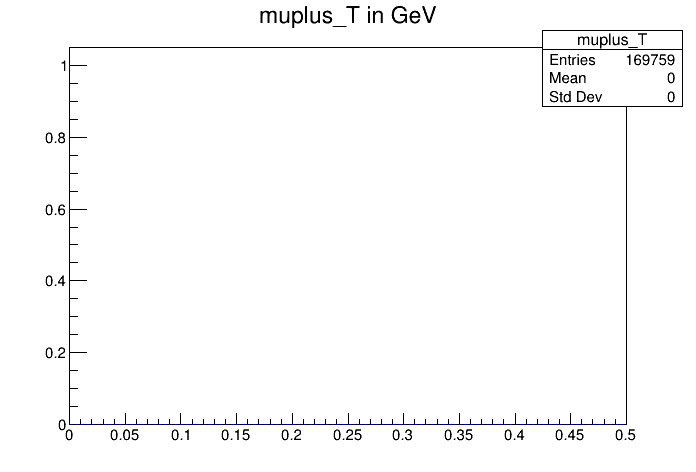

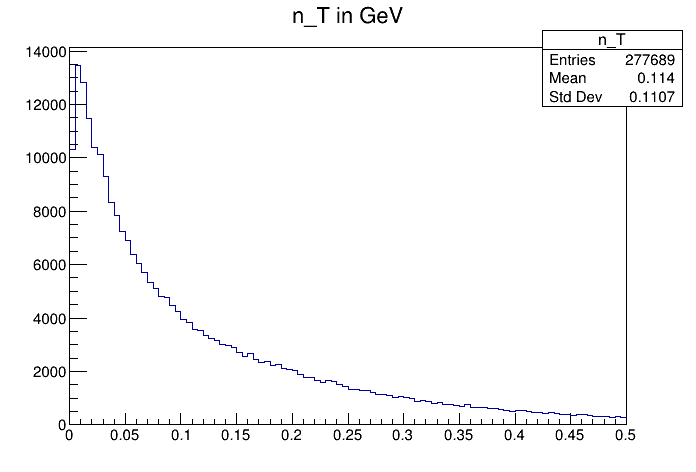

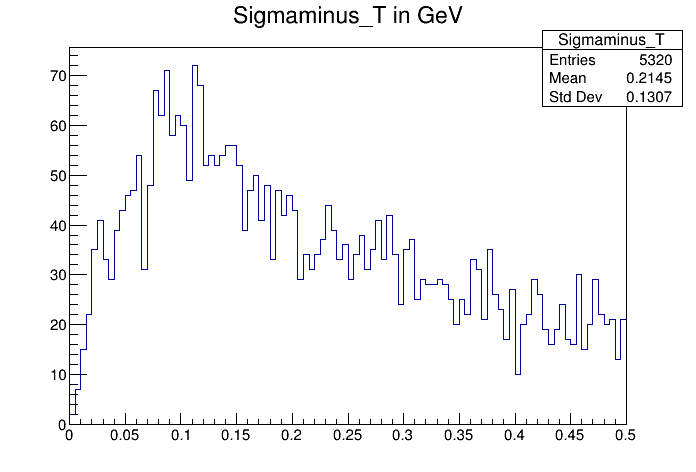

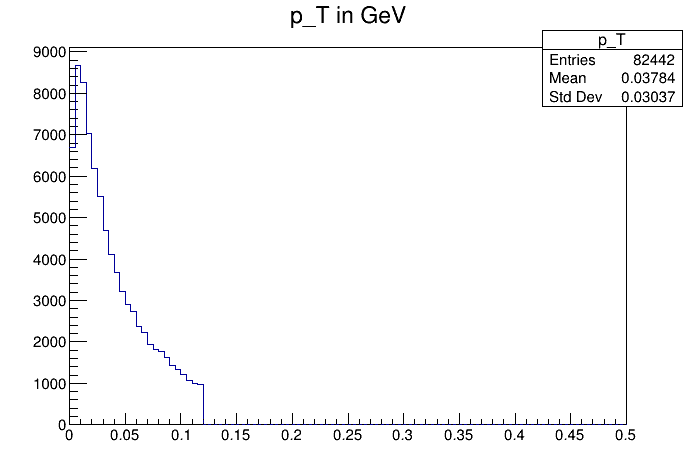

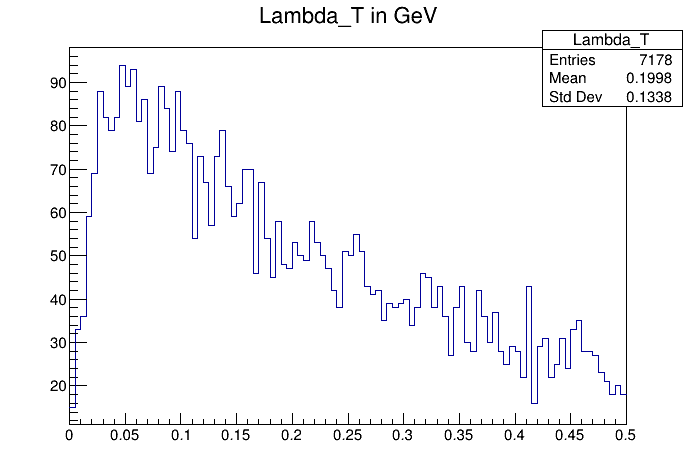

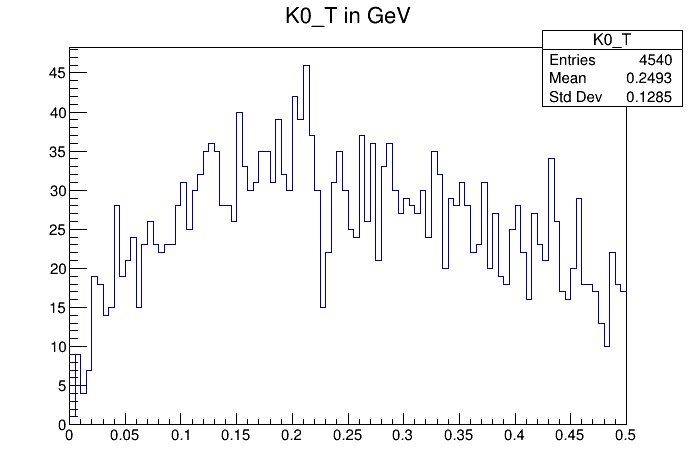

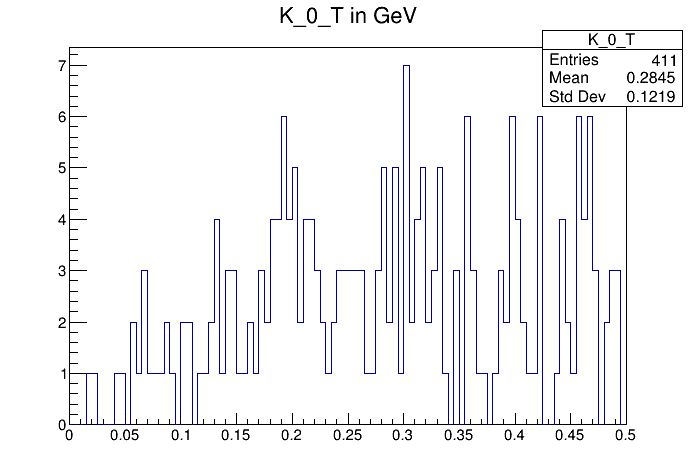

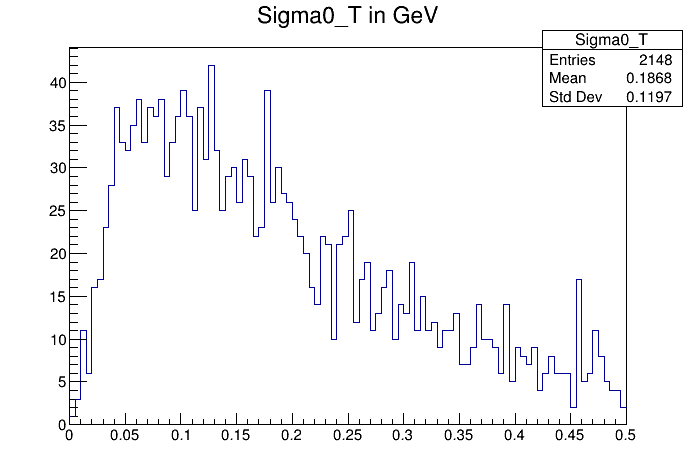

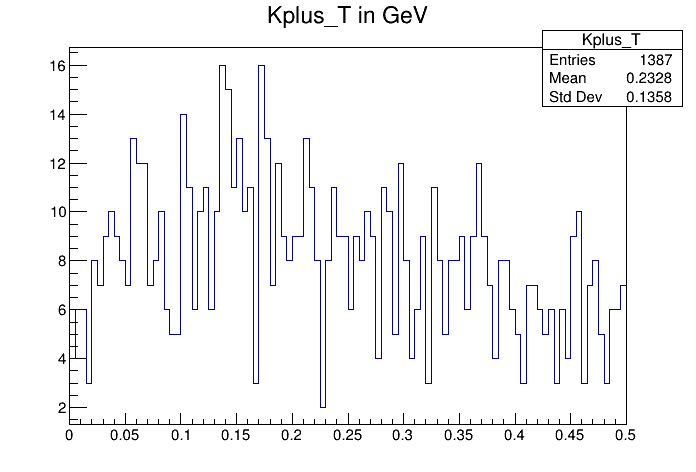

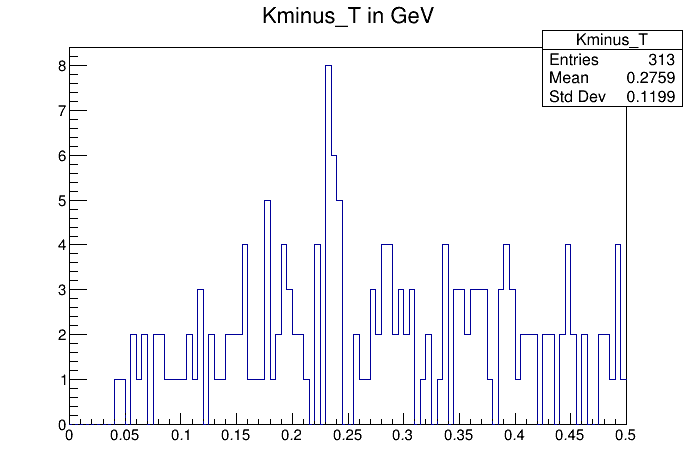

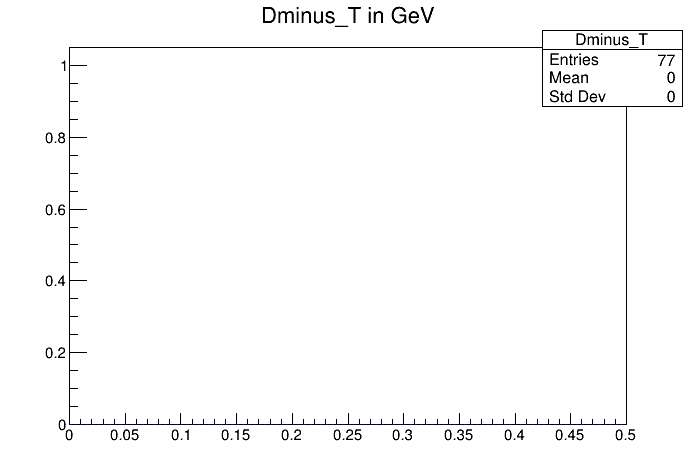

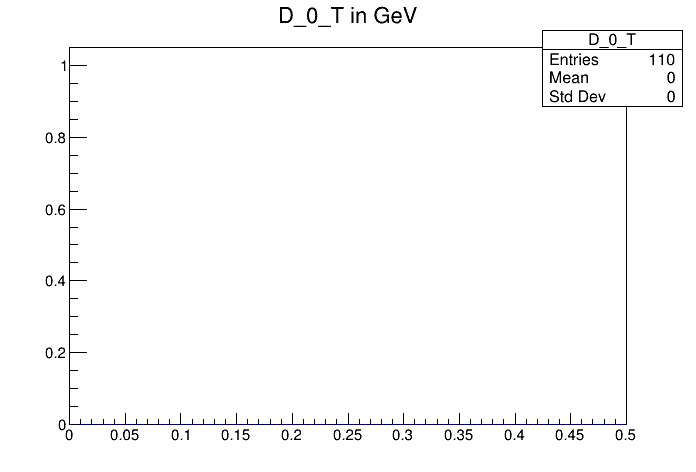

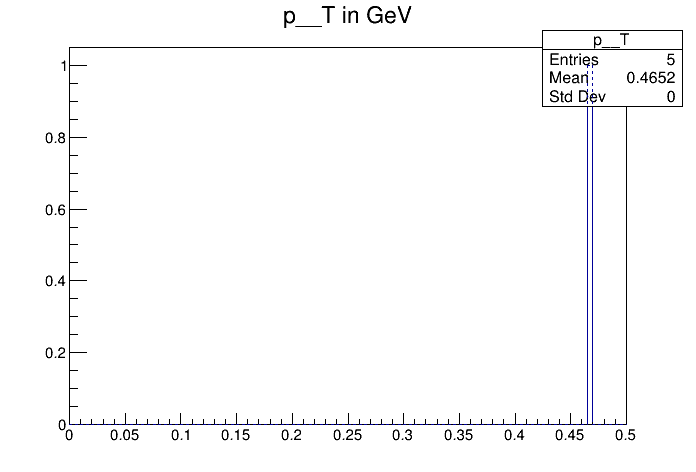

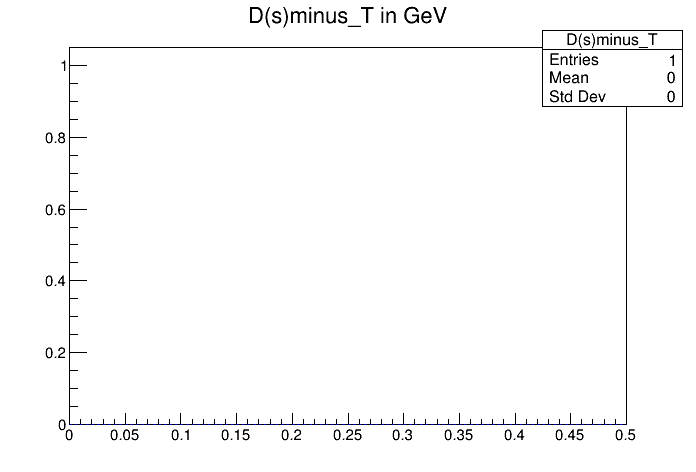

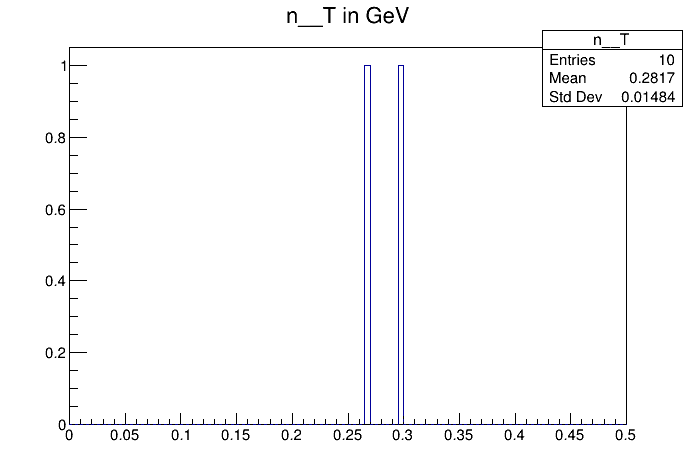

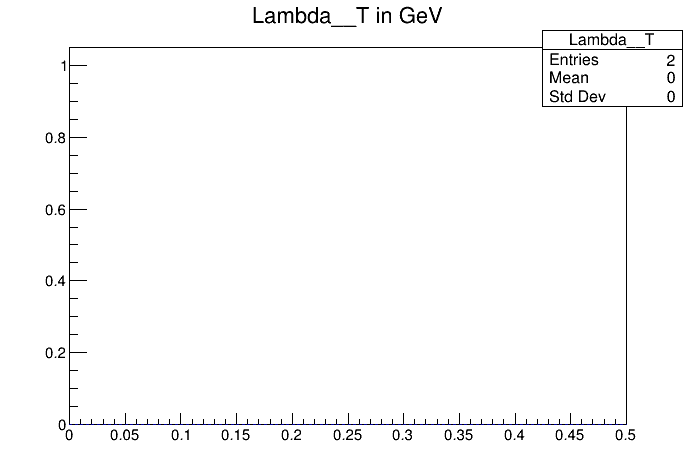

In [9]:

for baryon in baryons:
    hyperP[baryon].Print()
    hyperP[baryon].Write()
    hypercharged[baryon].Write()
    hyperzero[baryon].Write()
    hypertot0[baryon].Write()
    hypertotC[baryon].Write()
    hyperpass0[baryon].Write()
    hyperpassC[baryon].Write()
    

    print (hyperP[baryon].GetTitle(),"\t total ", hyperP[baryon].Integral(),"\t T < %f MeV "%ProtonCut,hyperP[baryon].Integral(1,24))
    print (hypercharged[baryon].GetTitle(),"\t total ", hypercharged[baryon].Integral(),"\t T<%f MeV "%PionCut,hypercharged[baryon].Integral(1,24))
    print (hyperzero[baryon].GetTitle(),"\t total ", hyperzero[baryon].Integral(),"\t T < %f MeV "%ProtonCut,hyperzero[baryon].Integral(1,24))
    print (hypertot0[baryon].GetTitle(),"\t total ", hypertot0[baryon].Integral())#,"\t T < %f MeV ",hypertot0[baryon].Integral(1,24))
    print (hypertotC[baryon].GetTitle(),"\t total ", hypertotC[baryon].Integral())#,"\t T < %f MeV ",hypertotC[baryon].Integral(1,24))
    print (hyperpass0[baryon].GetTitle(),"\t total ", hyperpass0[baryon].Integral())#,"\t T < %f MeV ",hyperpass0[baryon].Integral(1,24))
    print (hyperpassC[baryon].GetTitle(),"\t total ", hyperpassC[baryon].Integral())#,"\t T < %f MeV ",hyperpassC[baryon].Integral(1,24))

cs = {}
for h in parts:
    cs[h] = TCanvas()
    parts[h].Write()
    partT[h].Draw("hist")
    partT[h].Write()
    partTs[h].SetLineStyle(2)
    partTs[h].Write()
    partTs[h].Draw("hist same")
    cs[h].Draw()

    print ((Particle.from_pdgid(h)),"\t total ", parts[h].Integral(),"\t n<120 MeV ",partTs[h].Integral(1,24))
pions.Write()
photons.Write()

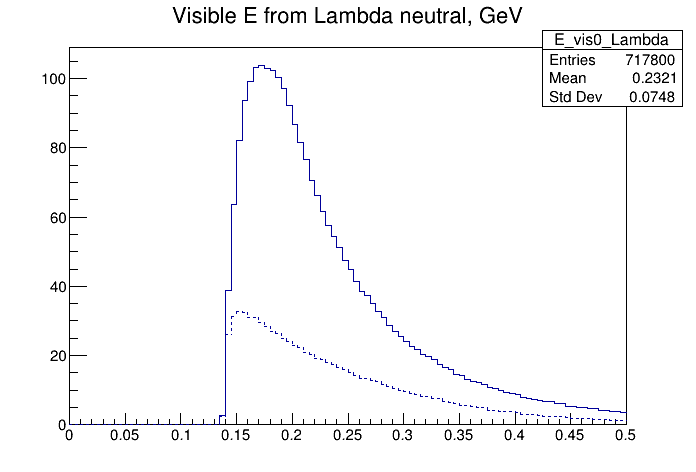

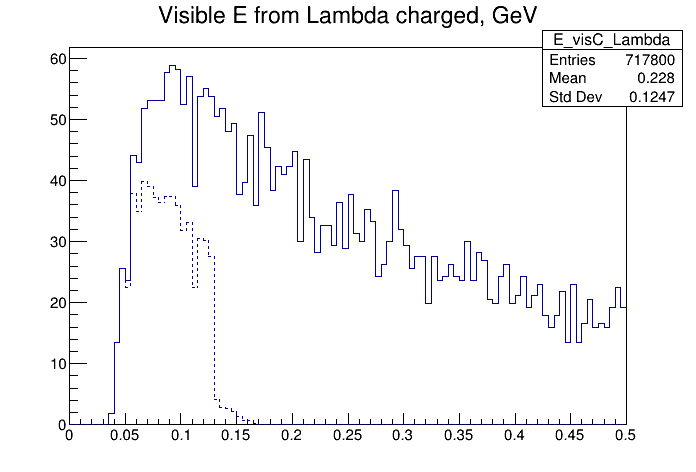

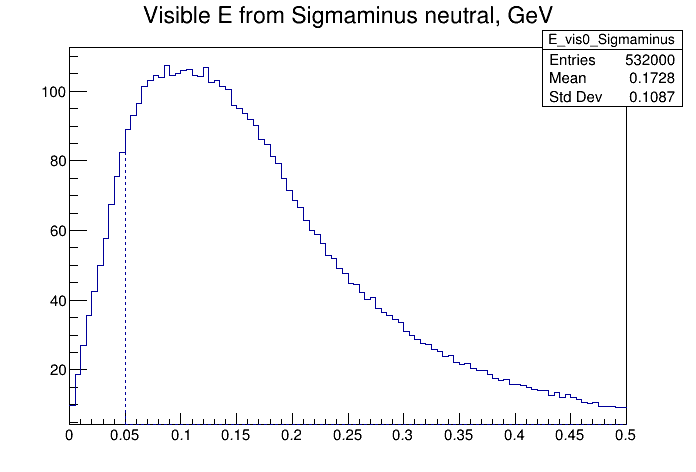

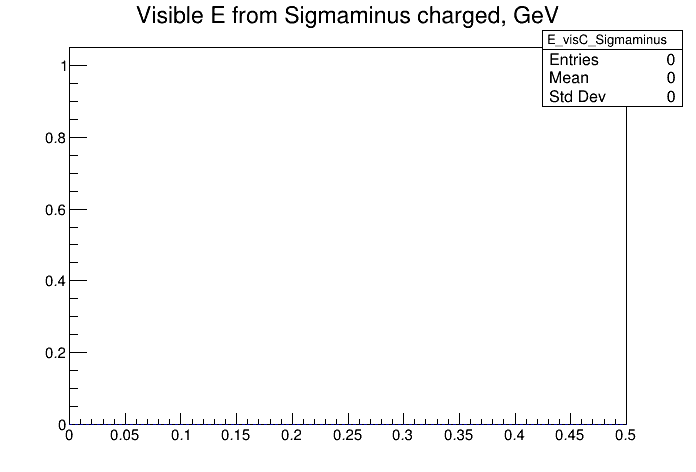

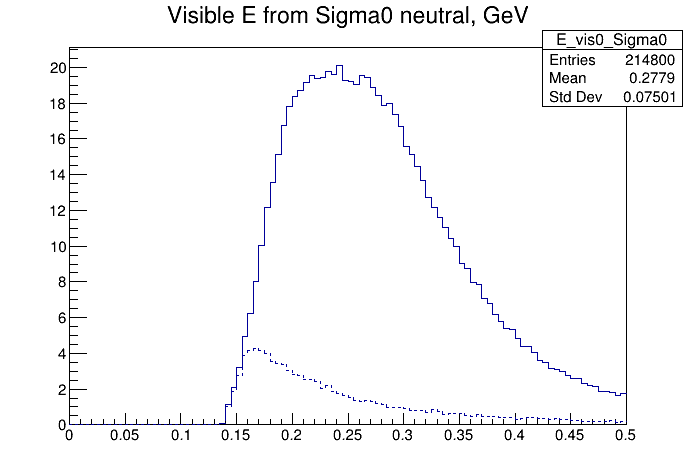

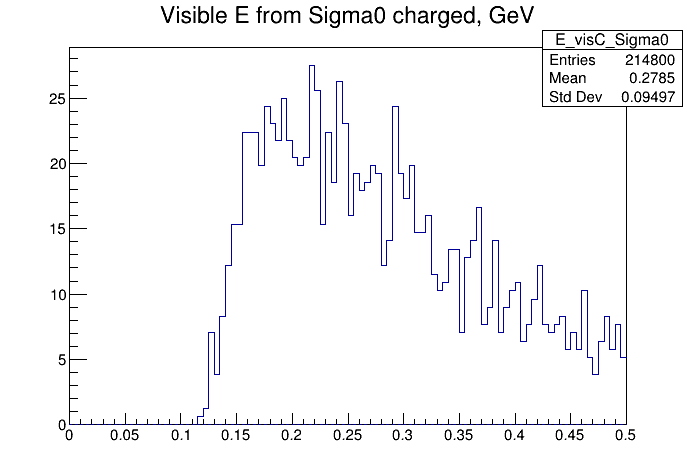

In [10]:
c10 = {}
c1C = {}
for baryon in baryons:
    c10[baryon] = TCanvas()
    hypertot0[baryon].Draw("hist")
    hyperpass0[baryon].SetLineStyle(2)
    hyperpass0[baryon].Draw("hist same")
    c10[baryon].Draw()
    c1C[baryon] = TCanvas()
    hypertotC[baryon].Draw("hist")
    hyperpassC[baryon].SetLineStyle(2)
    hyperpassC[baryon].Draw("hist same")
    c1C[baryon].Draw()

In [11]:
outputfile.Close()
inputfile.Close()

In [12]:
# variables from MakeClass on flat_GENIE_1000k_tune_G18_02a_02_11a_50MCombined_RHC.root for the MINERvA tracker
 #  Int_t           Mode;
 #  Char_t          cc;
 #  Int_t           PDGnu;
 #  Float_t         Enu_true;
 #  Int_t           tgt;
 #  Int_t           tgta;
 #  Int_t           tgtz;
 #  Int_t           PDGLep;
 #  Float_t         ELep;
 #  Float_t         CosLep;
 #  Float_t         Q2;
 #  Float_t         q0;
 #  Float_t         q3;
 #  Float_t         Enu_QE;
 #  Float_t         Q2_QE;
 #  Float_t         W_nuc_rest;
 #  Float_t         W;
 #  Float_t         W_genie;
 #  Float_t         x;
 #  Float_t         y;
 #  Float_t         Eav;
 #  Float_t         EavAlt;
 #  Float_t         CosThetaAdler;
 #  Float_t         PhiAdler;
 #  Float_t         dalphat;
 #  Float_t         dpt;
 #  Float_t         dphit;
 #  Float_t         pnreco_C;
 #  Int_t           nfsp;
 #  Float_t         px[30];   //[nfsp]
 #  Float_t         py[30];   //[nfsp]
 #  Float_t         pz[30];   //[nfsp]
 #  Float_t         E[30];   //[nfsp]
 #  Int_t           pdg[30];   //[nfsp]
 #  Int_t           pdg_rank[30];   //[nfsp]
 #  Int_t           ninitp;
 #  Float_t         px_init[7];   //[ninitp]
 #  Float_t         py_init[7];   //[ninitp]
 #  Float_t         pz_init[7];   //[ninitp]
 #  Float_t         E_init[7];   //[ninitp]
 #  Int_t           pdg_init[7];   //[ninitp]
 #  Int_t           nvertp;
 #  Float_t         px_vert[23];   //[nvertp]
 #  Float_t         py_vert[23];   //[nvertp]
 #  Float_t         pz_vert[23];   //[nvertp]
 #  Float_t         E_vert[23];   //[nvertp]
 #  Int_t           pdg_vert[23];   //[nvertp]
 #  Float_t         Weight;
 #  Float_t         InputWeight;
 #  Float_t         RWWeight;
 #  Double_t        fScaleFactor;
 #  Float_t         CustomWeight;
 #  Float_t         CustomWeightArray[6];
 #  Bool_t          flagCCINC;
 #  Bool_t          flagNCINC;
 #  Bool_t          flagCCQE;
 #  Bool_t          flagCC0pi;
 #  Bool_t          flagCCQELike;
 #  Bool_t          flagNCEL;
 #  Bool_t          flagNC0pi;
 #  Bool_t          flagCCcoh;
 #  Bool_t          flagNCcoh;
 #  Bool_t          flagCC1pip;
 #  Bool_t          flagNC1pip;
 #  Bool_t          flagCC1pim;
 #  Bool_t          flagNC1pim;
 #  Bool_t          flagCC1pi0;
 #  Bool_t          flagNC1pi0;
 #  Bool_t          flagCC0piMINERvA;
 #  Bool_t          flagCC0Pi_T2K_AnaI;
 #  Bool_t          flagCC0Pi_T2K_AnaII;